In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# Custom module
import ACF_calc

In [2]:
### Analysis Parameters

# Survey parameters
TARGET_REDSHIFT = 5          # Redshift bin: z=5 to z=6 (dz=1.0)
ABS_MAG_CUT = -17.0         # Absolute magnitude cut
PX_SCALE = 0.03             # Map pixel scale [arcsec/pixel]

# Angular correlation function parameters
THETA_MIN, THETA_MAX = 0.4, 200  # Angular range [arcsec]
N_BIN = 26                       # Number of angular bins
BIN_EDGES = np.logspace(np.log10(THETA_MIN), np.log10(THETA_MAX), N_BIN)

# Resampling parameters
N_ITER = 50                 # Number of iterations
DATA_PERC = 0.4            # Bootstrap: fraction of data to sample
RAND_MULT = 20             # Bootstrap: random point multiplier
CIRC_RADIUS = 100          # Jackknife: circular exclusion radius [arcsec]

In [3]:
### Load Coordinate Data

# Load data and random coordinates
data_file = f"coordinate_data/coo_data_mag{ABS_MAG_CUT}_z{TARGET_REDSHIFT}.0.txt"
rand_file = f"coordinate_data/coo_rand_mag{ABS_MAG_CUT}_z{TARGET_REDSHIFT}.0.txt"

data_coords = np.loadtxt(data_file)
rand_coords = np.loadtxt(rand_file)

# Extract coordinates
data_X, data_Y, data_Z = data_coords[:, 0], data_coords[:, 1], data_coords[:, 2]
rand_X, rand_Y = rand_coords[:, 0], rand_coords[:, 1]

# Package coordinates for analysis
coo_data = (data_X, data_Y)
coo_rand = (rand_X, rand_Y)

# Calculate mean redshift
z_mean = np.mean(data_Z)

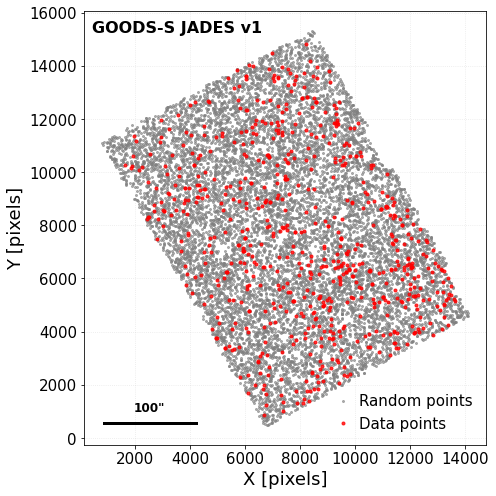

In [4]:
### Survey Field Visualization

fig, ax = plt.subplots(figsize=(7, 7))
fig.patch.set_facecolor('white')

# Plot points
ax.plot(rand_X, rand_Y, '.', label='Random points', 
        alpha=0.6, markersize=4, color='gray')
ax.plot(data_X, data_Y, '.', label='Data points', 
        alpha=0.8, markersize=6, color='red')

# Add reference scale bar
reference_length_pixels = CIRC_RADIUS / PX_SCALE
x_start = ax.get_xlim()[0] + 0.05 * np.diff(ax.get_xlim())[0]
y_start = ax.get_ylim()[0] + 0.05 * np.diff(ax.get_ylim())[0]

ax.plot([x_start, x_start + reference_length_pixels], 
        [y_start, y_start], 'k-', linewidth=3)

# Scale bar label
text_x = x_start + reference_length_pixels / 2
text_y = y_start + 0.02 * np.diff(ax.get_ylim())[0]
ax.text(text_x, text_y, f'{CIRC_RADIUS}"', 
        ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_xlabel('X [pixels]', fontsize=18)
ax.set_ylabel('Y [pixels]', fontsize=18)
ax.tick_params(axis='both', labelsize=15)

# Dataset info
ax.text(0.02, 0.98, 'GOODS-S JADES v1', transform=ax.transAxes, 
        fontsize=16, va='top', ha='left', weight='bold')

ax.grid(alpha=0.3, linestyle=':')
ax.legend(fontsize=15, loc='lower right', frameon=False, handletextpad=0.1)

plt.tight_layout()
plt.show()

In [5]:
## Angular Correlation Function Analysis

### Bootstrap Analysis
w_array_boot, cov_boot, w0_mean_boot, bin_centre_boot, dd_pairs_boot, dr_pairs_boot, rr_pairs_boot = \
    ACF_calc.bootstrap(coo_data, coo_rand, BIN_EDGES, N_ITER, DATA_PERC, RAND_MULT, PX_SCALE, hist=True)

# Covariance errors
w0_mean_err_boot = np.sqrt(np.diag(cov_boot))

### Jackknife Analysis
w_array_jack, cov_jack, w0_mean_jack, bin_centre_jack, dd_pairs_jack, dr_pairs_jack, rr_pairs_jack = \
    ACF_calc.jackknife(coo_data, coo_rand, BIN_EDGES, N_ITER, CIRC_RADIUS, PX_SCALE, hist=True)

# Covariance errors
w0_mean_err_jack = np.sqrt(np.diag(cov_jack))

Jackknife: 100%|██████████| 50/50 [00:48<00:00,  1.04iteration/s]


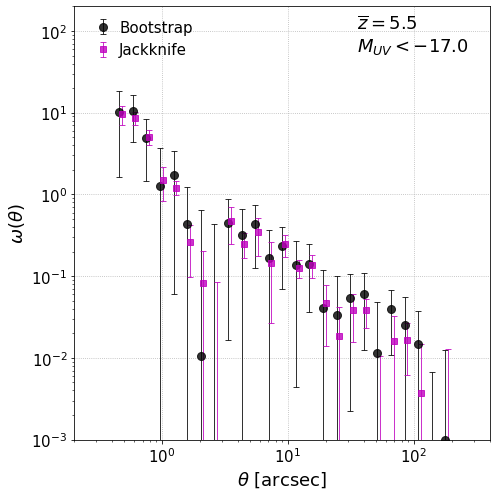

In [6]:
### Angular Correlation Function Plot

fig, ax = plt.subplots(figsize=(7, 7))
fig.patch.set_facecolor('white')

# Bootstrap results
ax.errorbar(bin_centre_boot, w0_mean_boot, yerr=w0_mean_err_boot, 
            fmt='ko', capsize=3, elinewidth=1, markersize=8, 
            label='Bootstrap', alpha=0.8)

# Jackknife results (slightly offset for visibility)
ax.errorbar(1.05 * bin_centre_jack, w0_mean_jack, yerr=w0_mean_err_jack, 
            fmt='ms', capsize=3, elinewidth=1, markersize=6, 
            label='Jackknife', alpha=0.8)

# Formatting
ax.set_ylabel(r'$\omega(\theta)$', fontsize=18)
ax.set_xlabel(r'$\theta$ [arcsec]', fontsize=18)
ax.tick_params(axis='both', labelsize=15)

# Sample information
info_text = f'$\\overline{{z}} = {z_mean:.1f}$\n$M_{{UV}} < {ABS_MAG_CUT:.1f}$'
ax.text(0.68, 0.98, info_text, transform=ax.transAxes, fontsize=18, 
        va='top', ha='left')

# Set scales and limits
ax.set_xlim(0.5 * THETA_MIN, 2 * THETA_MAX)
ax.set_ylim(1e-3, 2e2)
ax.loglog()

ax.grid(linestyle=':')
ax.legend(fontsize=15, loc='upper left', frameon=False, handletextpad=0.1)

plt.tight_layout()
plt.show()